In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pickle
from torch import nn
import torch.nn.functional as F
# from sklearn.metrics import roc_curve, auc
from torch.autograd import Variable
plt.rcParams.update({'font.size': 15})
device = torch.device('cuda:7' if torch.cuda.is_available() else 'cpu')
from sklearn.decomposition import PCA, TruncatedSVD, NMF
from scipy.optimize import minimize
from scipy import signal
from sklearn import linear_model
from sklearn.metrics import roc_curve, roc_auc_score, auc
import geatpy as ea

: 

In [4]:
with open('/home/mjy/project/bilinear_network/2021Neuron/L5PC/output/L5PC__activeDendrites_Ih_vshift_0_SKE2_mult_100__AMPA_GABA_A/exBas_0_800_inhBasDiff_-600_200__exApic_0_800_inhApicDiff_-600_200__saved_InputSpikes___0_outSpikes__2_simulationRuns__6_secDuration__randomSeed_53789.p', 'rb') as fo:
    data = pickle.load(fo, encoding='bytes')

In [5]:
len(data['Results']['listOfSingleSimulationDicts'])

2

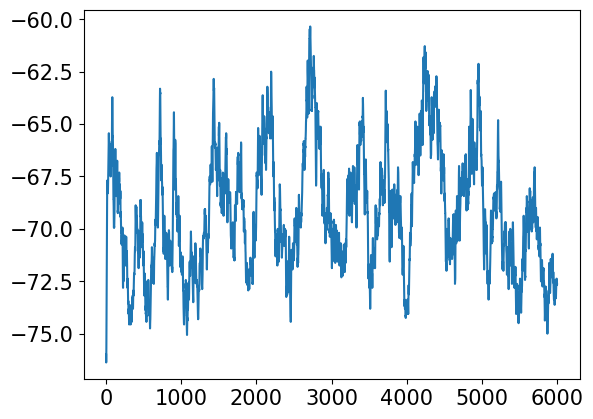

In [6]:
a = data['Results']['listOfSingleSimulationDicts'][1]['somaVoltageLowRes']
plt.plot(a)

In [25]:
X_train = np.empty([2, 1278, 6000])
Y_train = np.empty([2, 6000])
for i in range(len(data['Results']['listOfSingleSimulationDicts'])):
    X_train[i][:639, :] = data['Results']['listOfSingleSimulationDicts'][i]['inputSpikeTrains_ex']
    X_train[i][639:, :] = data['Results']['listOfSingleSimulationDicts'][i]['inputSpikeTrains_inh']
    Y_train[i] = data['Results']['listOfSingleSimulationDicts'][i]['somaVoltageLowRes']
# X_train[0][:639, :] = data['Results']['listOfSingleSimulationDicts'][1]['inputSpikeTrains_ex']
# X_train[0][639:, :] = data['Results']['listOfSingleSimulationDicts'][1]['inputSpikeTrains_inh']
# Y_train[0] = data['Results']['listOfSingleSimulationDicts'][1]['somaVoltageLowRes']

In [26]:
Y_train.shape

(2, 6000)

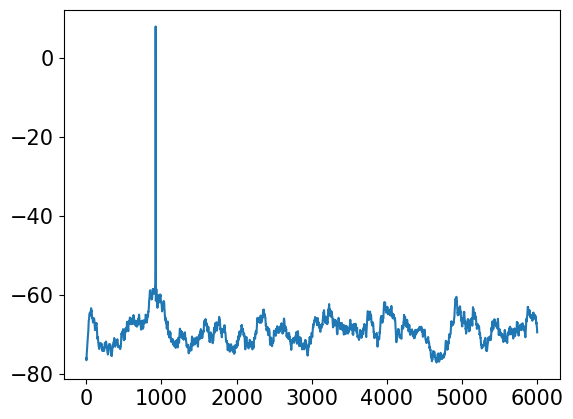

In [27]:
plt.plot(Y_train[0])

In [28]:
Y_train_ori = Y_train.copy()
# Y_test_ori = Y_test.copy()

In [29]:
# thresholding
threshold = -58
Y_train[Y_train > threshold] = threshold

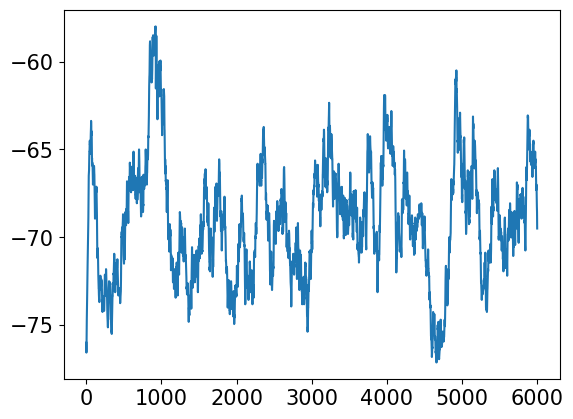

In [30]:
plt.plot(Y_train[0])

Text(0, 0.5, 'MP(mV)')

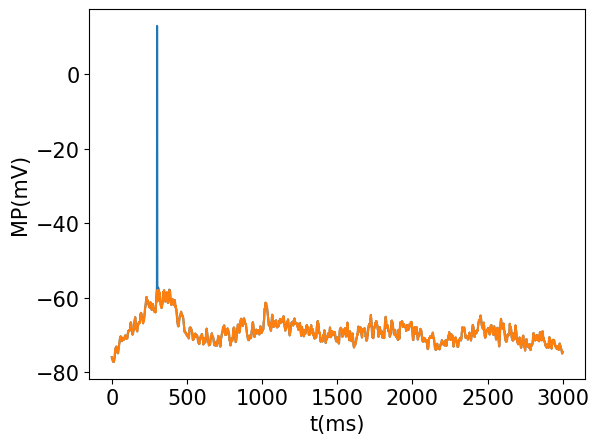

In [244]:
t = np.linspace(0, 3000, 3000)
plt.plot(t, Y_train_ori[2])
plt.plot(t, Y_train[2])
plt.xlabel('t(ms)')
plt.ylabel('MP(mV)')
#plt.savefig('figure/thresholding', bbox_inches='tight')

In [31]:
# pre-processing
## standardization
Y_train_std = np.empty_like(Y_train)
# Y_test_std = np.empty_like(Y_test)
Y_train_std = (Y_train - np.mean(Y_train)) / np.std(Y_train)
# Y_test_std = (Y_test - np.mean(Y_test)) / np.std(Y_test)

# X_train_std = list2array(X_train)
# X_test_std = list2array(X_test)
X_train_std = X_train

## from numpy to pytorch
Y_train_std = torch.tensor(Y_train_std).to(device)
Y_train_std = Y_train_std.to(torch.float32)

# Y_test_std = torch.tensor(Y_test_std).to(device)
# Y_test_std = Y_test_std.to(torch.float32)

X_train_std = torch.tensor(X_train_std).to(device)
X_train_std = X_train_std.to(torch.float32)

# X_test_std = torch.tensor(X_test_std).to(device)
# X_test_std = X_test_std.to(torch.float32)

In [32]:
train = Variable(X_train_std)

In [33]:
X_train_std.size()

torch.Size([2, 1278, 6000])

In [34]:
def kernel(time_dur, tau_rise, tau_decay):
    T = torch.arange(time_dur).to(device)
    y = (1 - torch.exp(-T / tau_rise)) * torch.exp(-T / tau_decay)
    return torch.flip(y, dims=[0])

def Kernel(time_dur, in_channels, Tau_rise, Tau_decay):
    y = torch.empty(1, in_channels, time_dur)
    for i in range(in_channels):
        y[0, i] = kernel(time_dur, Tau_rise[i], Tau_decay[i])
    return y.to(device)

def spike_time_mask(spike_time):
    mask = torch.ones(len(spike_time), 15001)
    for i in range(len(spike_time)):
        for time in spike_time[i]:
            mask[i][int(time)*5-350:int(time)*5+650] = 0
    return mask

In [42]:
class model_l(nn.Module):
    def __init__(self, time_dur, in_channels):
        super(model_l, self).__init__()
        self.time_dur = time_dur
        self.in_channels = in_channels
        weight = torch.cat((torch.ones((1, 639, 1), requires_grad=True) * 0.05, torch.ones((1, 639, 1), requires_grad=True) * -0.02), dim=1)
        self.weight = nn.Parameter(weight)
        # Tau_rise = torch.ones(1278, requires_grad=True) * 2
        Tau_rise = torch.rand((1278), requires_grad=True) * 5 + 1
        # Tau_rise = torch.cat((torch.tensor(([0.1, 1.]*319), requires_grad=True), torch.ones(640, requires_grad=True)*0.1), dim=0)
        self.Tau_rise = nn.Parameter(Tau_rise)
        # Tau_decay = torch.ones(1278, requires_grad=True) * 8
        Tau_decay = torch.rand((1278), requires_grad=True) * 10 + 7
        # Tau_decay = torch.cat((torch.tensor(([1., 9.]*319), requires_grad=True), torch.ones(640, requires_grad=True)*1), dim=0)
        self.Tau_decay = nn.Parameter(Tau_decay)
        bias = torch.ones(1, requires_grad=True) * -2
        self.bias = nn.Parameter(bias)

    def forward(self, x):
        filter = Kernel(time_dur=self.time_dur, in_channels=self.in_channels, Tau_rise=self.Tau_rise, Tau_decay=self.Tau_decay) * self.weight
        x = F.conv1d(x, filter, padding=self.time_dur-1, bias=self.bias)
        x = torch.squeeze(x)[:, :self.time_dur]
        return x

class MaskedMSELoss(torch.nn.Module):
    def __init__(self):
        super(MaskedMSELoss, self).__init__()

    def forward(self, input, target, mask):
        diff2 = (input - target) ** 2 * mask
        return torch.sum(diff2) / torch.sum(mask)

In [43]:
N_sample = X_train_std.shape[0]
in_channels = X_train_std.shape[1]
time_dur = X_train_std.shape[2]
net = model_l(time_dur, in_channels)
net.to(device)
error = nn.MSELoss()
error_mask = MaskedMSELoss()
learning_rate = 0.01
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)

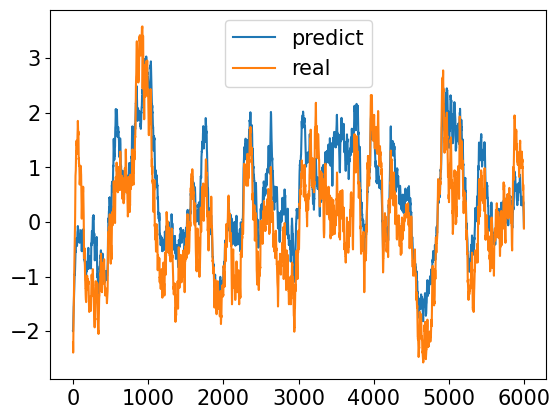

In [44]:
idx = 0
output = net(train)
plt.plot(output[idx].cpu().detach().numpy(), label='predict')
plt.plot(Y_train_std[idx].cpu().detach().numpy(), label='real')
plt.legend()

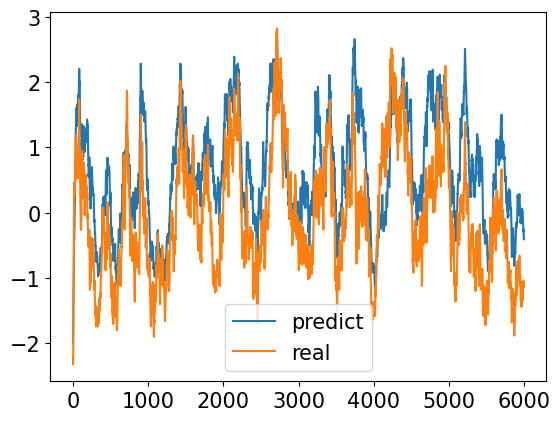

In [45]:
idx = 1
output = net(train)
plt.plot(output[idx].cpu().detach().numpy(), label='predict')
plt.plot(Y_train_std[idx].cpu().detach().numpy(), label='real')
plt.legend()

In [46]:
train = Variable(X_train_std)
tr_labels = Variable(Y_train_std)
output = net(train)
error(output, tr_labels)

tensor(0.6441, device='cuda:7', grad_fn=<MseLossBackward0>)

In [47]:
# ANN model training
num_epochs = 1000
loss_train_list = []
iteration_list = []
loss_test_list = []
train = Variable(X_train_std)
tr_labels = Variable(Y_train_std)
# test = Variable(X_test_std)
# test_labels = Variable(Y_test_std)
# mask_tr = spike_time_mask(tr_spike_time)
# mask_tr = mask_tr.to(device)
# mask_test = spike_time_mask(test_spike_time)
# mask_test = mask_test.to(device)
for epoch in range(num_epochs):
    outputs = net(train) # Forward propagation
    loss_train = error(outputs, tr_labels)
    #loss_train = error_mask(outputs, tr_labels, mask_tr) # Calculate loss
    loss_train.backward() # Calculating gradients
    #loss_train.backward(retain_graph=True) 
    optimizer.step() # Update parameters
    optimizer.zero_grad() # Clear gradients
        
    if epoch % 100 == 0:        
        # Predict test dataset
        #outputs = net(test) # Forward propagation
        #loss_test = error(outputs, test_labels)
        #loss_test = error_mask(outputs, test_labels, mask_test)
        # store loss and iteration
        loss_train_list.append(loss_train.data.item())
        iteration_list.append(epoch)
        #loss_test_list.append(loss_test.data.item())
    if epoch % 100 == 0:
        print('Iteration: {}  Train_Loss: {}  '.format(epoch, loss_train.data.item()))
print('Final: Train_Loss: {}  '.format(loss_train.data.item()))

Iteration: 0  Train_Loss: 0.6441221237182617  
Iteration: 100  Train_Loss: 0.09969042986631393  
Iteration: 200  Train_Loss: 0.06569719314575195  
Iteration: 300  Train_Loss: 0.051302652806043625  
Iteration: 400  Train_Loss: 0.043062128126621246  
Iteration: 500  Train_Loss: 0.03770119324326515  
Iteration: 600  Train_Loss: 0.033947378396987915  
Iteration: 700  Train_Loss: 0.031172599643468857  
Iteration: 800  Train_Loss: 0.029034387320280075  
Iteration: 900  Train_Loss: 0.02732890285551548  
Final: Train_Loss: 0.02594582550227642  


In [262]:
output = net(train)
for i in range(10):
    print(error(output[i], tr_labels[i]))

tensor(0.1827, device='cuda:7', grad_fn=<MseLossBackward0>)
tensor(0.1215, device='cuda:7', grad_fn=<MseLossBackward0>)
tensor(0.1603, device='cuda:7', grad_fn=<MseLossBackward0>)
tensor(0.2397, device='cuda:7', grad_fn=<MseLossBackward0>)
tensor(0.1634, device='cuda:7', grad_fn=<MseLossBackward0>)
tensor(0.1486, device='cuda:7', grad_fn=<MseLossBackward0>)
tensor(0.1591, device='cuda:7', grad_fn=<MseLossBackward0>)
tensor(0.1474, device='cuda:7', grad_fn=<MseLossBackward0>)
tensor(0.1220, device='cuda:7', grad_fn=<MseLossBackward0>)
tensor(0.1428, device='cuda:7', grad_fn=<MseLossBackward0>)


In [263]:
output = net(train)
for i in range(10):
    print(torch.sum((output[i]-Y_train_std[i])**2) / torch.sum((torch.mean(Y_train_std[i])-Y_train_std[i])**2))

tensor(0.1748, device='cuda:7', grad_fn=<DivBackward0>)
tensor(0.2219, device='cuda:7', grad_fn=<DivBackward0>)
tensor(0.1534, device='cuda:7', grad_fn=<DivBackward0>)
tensor(0.1941, device='cuda:7', grad_fn=<DivBackward0>)
tensor(0.1139, device='cuda:7', grad_fn=<DivBackward0>)
tensor(0.1462, device='cuda:7', grad_fn=<DivBackward0>)
tensor(0.1338, device='cuda:7', grad_fn=<DivBackward0>)
tensor(0.2173, device='cuda:7', grad_fn=<DivBackward0>)
tensor(0.1186, device='cuda:7', grad_fn=<DivBackward0>)
tensor(0.2830, device='cuda:7', grad_fn=<DivBackward0>)


In [49]:
y = output[idx].cpu().detach().numpy()*np.std(Y_train)+np.mean(Y_train)
z = Y_train_std[idx].cpu().detach().numpy()*np.std(Y_train)+np.mean(Y_train)
y[230:320] += 2
# y[:400] += 1
# y[2653:2670] -= 2
# y[353:357] += 2
# # y[361:365] += 2
# y[410:415] += 2
# y[2620:2625] += 2
# # y[330:400] -= 2

Text(0, 0.5, 'V(mV)')

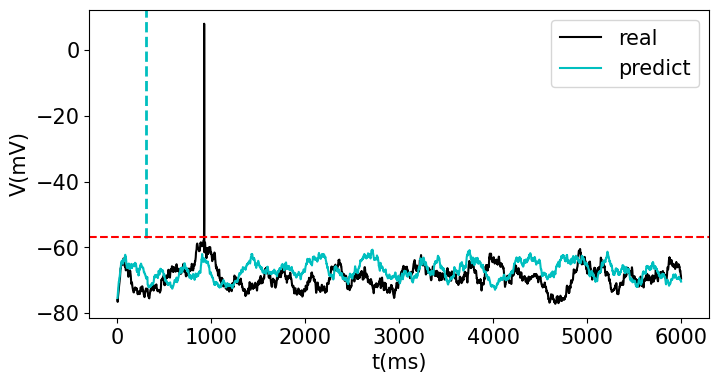

In [51]:
idx = 0
plt.figure(figsize=(8,4))
plt.xlabel('time(ms)')
plt.ylabel('voltage(mV)')
plt.plot(Y_train_ori[idx], color='black', label='real')
plt.plot(y, color='c', label='predict')
# plt.axvline(357, ymin=0.26, ymax=1, c='c', ls='--')
# plt.axvline(154.5, ymin=0.26, ymax=0.95, c='black', ls='-',linewidth='1.8')
# plt.axvline(356, ymin=0.26, ymax=0.95, c='black', ls='-',linewidth='2')
# plt.axvline(2624, ymin=0.26, ymax=0.95, c='black', ls='-',linewidth='1.7')

plt.axvline(302, ymin=0.26, ymax=1, c='c', ls='--',linewidth='2')
# plt.axvline(408, ymin=0.22, ymax=1, c='c', ls='--',linewidth='2')
# plt.axvline(2624, ymin=0.26, ymax=1, c='c', ls='--',linewidth='2')
# plt.plot(y, color='c', label='predict')
# plt.ylim(-85, -60)
plt.axhline(-57, c='r', ls='--')
plt.legend()
plt.xlabel('t(ms)')
plt.ylabel('V(mV)')
# plt.savefig('figure/nmda_spike_2', bbox_inches='tight')

In [226]:
print(1 - np.sum((y-z)**2) / np.sum((np.mean(z)-z)**2))

0.9508869498968124


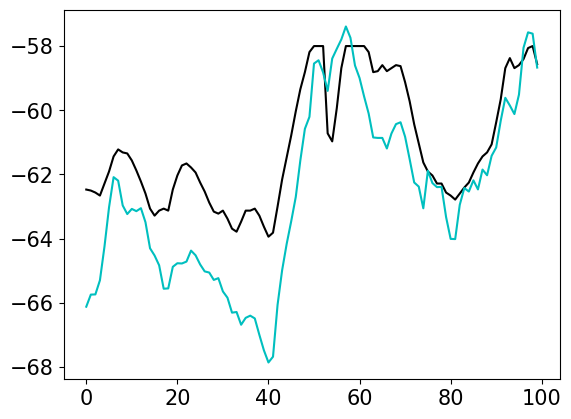

In [365]:
plt.plot(Y_train_std[idx][250:350].cpu().detach().numpy()*np.std(Y_train)+np.mean(Y_train), color='black', label='real')
plt.plot(y[250:350], color='c', label='predict')

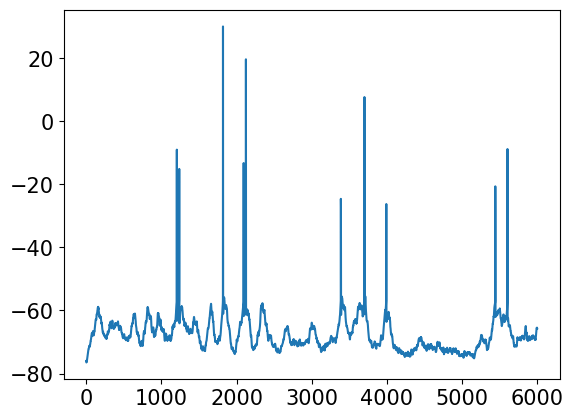

In [67]:
plt.plot(Y_train_ori[idx])

In [40]:
output = net(train)
for i in range(10):
    print(torch.sum((output[i]-Y_train_std[i])**2) / torch.sum((torch.mean(Y_train_std[i])-Y_train_std[i])**2))

tensor(0.0229, device='cuda:7', grad_fn=<DivBackward0>)
tensor(0.0262, device='cuda:7', grad_fn=<DivBackward0>)
tensor(0.0202, device='cuda:7', grad_fn=<DivBackward0>)
tensor(0.0249, device='cuda:7', grad_fn=<DivBackward0>)
tensor(0.0125, device='cuda:7', grad_fn=<DivBackward0>)
tensor(0.0262, device='cuda:7', grad_fn=<DivBackward0>)
tensor(0.0806, device='cuda:7', grad_fn=<DivBackward0>)
tensor(0.0453, device='cuda:7', grad_fn=<DivBackward0>)
tensor(0.0277, device='cuda:7', grad_fn=<DivBackward0>)
tensor(0.0081, device='cuda:7', grad_fn=<DivBackward0>)


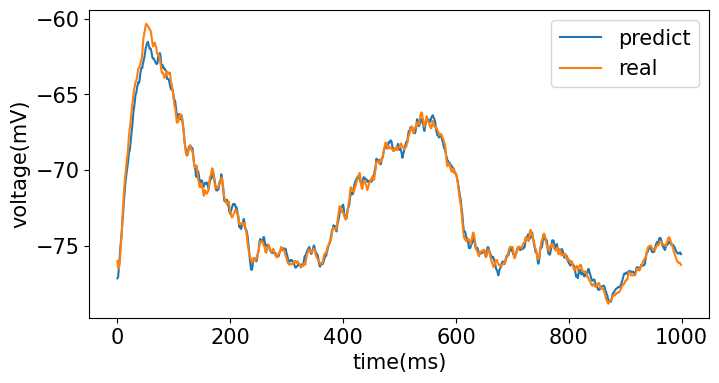

In [201]:
train = Variable(X_train_std)
output = net(train)
idx = 9
plt.figure(figsize=(8,4))
plt.xlabel('time(ms)')
plt.ylabel('voltage(mV)')
plt.plot(output[idx].cpu().detach().numpy()*np.std(Y_train)+np.mean(Y_train), label='predict')
plt.plot(Y_train_std[idx].cpu().detach().numpy()*np.std(Y_train)+np.mean(Y_train), label='real')
plt.legend()
# plt.savefig('figure/trace', bbox_inches='tight')

In [44]:
for name, parameters in net.named_parameters():
    print(name, ':', parameters.size())

weight : torch.Size([1, 1278, 1])
Tau_rise : torch.Size([1278])
Tau_decay : torch.Size([1278])
bias : torch.Size([1])


In [45]:
net.Tau_rise.size()

torch.Size([1278])

In [53]:
tau_rise_vec = net.Tau_rise.cpu().detach().numpy()[:639]
tau_decay_vec = net.Tau_decay.cpu().detach().numpy()[:639]

In [52]:
def create_single_PSP_kernel(tau_rise, tau_decay, temporal_filter_length):

    exp_r = signal.exponential(M=temporal_filter_length, center=0, tau=tau_rise , sym=False)
    exp_d = signal.exponential(M=temporal_filter_length, center=0, tau=tau_decay, sym=False)

    post_syn_potential = exp_d - exp_r
    post_syn_potential /= post_syn_potential.max()

    return post_syn_potential

def construct_normlized_synaptic_filter(tau_rise_vec, tau_decay_vec, time_dur):

    num_synapses = tau_rise_vec.shape[0]
    # temporal_filter_length = int(4 * tau_decay_vec.max()) + 1
    temporal_filter_length = time_dur

    syn_filter = np.zeros((num_synapses, temporal_filter_length))

    for k, (tau_r, tau_d) in enumerate(zip(tau_rise_vec, tau_decay_vec)):
        syn_filter[k,:] = create_single_PSP_kernel(tau_r, tau_d, temporal_filter_length=time_dur)

    return syn_filter

In [54]:
len(np.where(tau_rise_vec>tau_decay_vec)[0])

0

In [55]:
syn_filter = construct_normlized_synaptic_filter(tau_rise_vec, tau_decay_vec, 1000)

In [56]:
syn_filter.shape

(639, 1000)

In [57]:
syn_filter = syn_filter[:, :120]

In [58]:
neg_index = np.where(tau_rise_vec > tau_decay_vec)[0]
neg_index

array([], dtype=int64)

In [60]:
normalized_syn_filter = np.delete(syn_filter, neg_index, axis=0)

In [61]:
normalized_syn_filter.shape

(639, 120)

In [ ]:
cmap = matplotlib.colors.ListedColormap(matplotlib.cm.get_cmap("Set3").colors[:5])
plt.scatter(np.random.uniform(0, 10, 50), np.random.uniform(0, 10, 50), c=np.random.uniform(0, 10, 50), cmap=cmap)

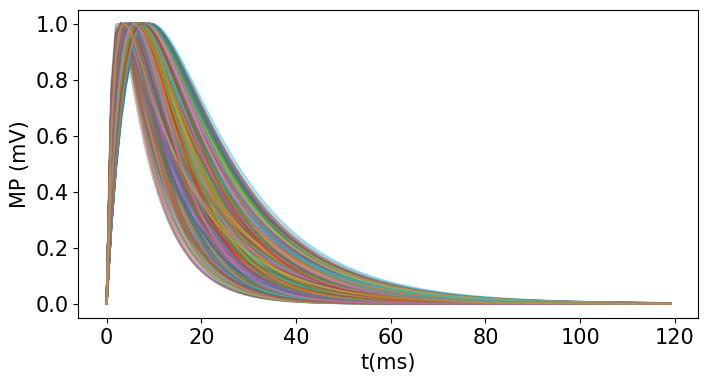

In [105]:
plt.figure(figsize=(8,4))
plt.plot(normalized_syn_filter.T ,alpha=0.5)
plt.xlabel('t(ms)')
plt.ylabel('MP (mV)')
# plt.title('normalized EPSP')
plt.savefig('figure/normalized_EPSP', bbox_inches='tight', dpi=800)

In [75]:
X = normalized_syn_filter
PSP_SVD_model = TruncatedSVD(n_components=100)
PSP_SVD_model.fit(X)

SVD_cutoff_ind = 3
max_SVD_basis_to_present = 18

In [76]:
PSP_SVD_model.singular_values_[:10]

array([8.84061585e+01, 1.41323454e+01, 4.89237294e+00, 1.28562004e+00,
       3.93736780e-01, 1.22247742e-01, 3.35133998e-02, 1.08086843e-02,
       3.14316199e-03, 8.63802971e-04])

Text(0.5, 0, 'index of singular vectors')

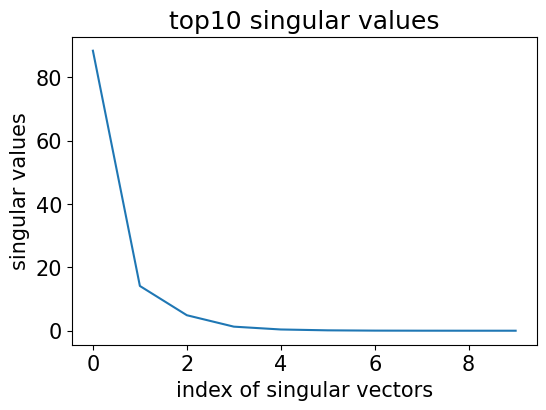

In [77]:
plt.figure(figsize=(6,4))
plt.plot(PSP_SVD_model.singular_values_[:10])
plt.title('top10 singular values')
plt.ylabel('singular values')
plt.xlabel('index of singular vectors')
# plt.savefig('figure/kernel_singular_value_top10', bbox_inches='tight')

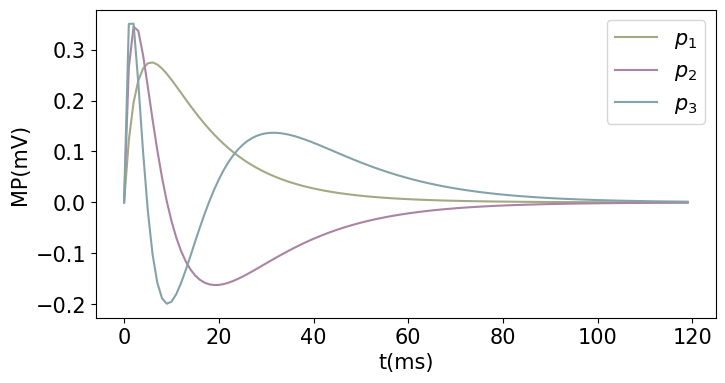

In [99]:
plt.figure(figsize=(8,4))
plt.plot(PSP_SVD_model.components_[0].T, c='#a3a984', label='$p_1$')
plt.plot(-PSP_SVD_model.components_[1].T, c='#a984a3', label='$p_2$')
plt.plot(PSP_SVD_model.components_[2].T, c='#84A3A9', label='$p_3$')
# plt.title('top3 singular vectors')
plt.xlabel('t(ms)')
plt.ylabel('MP(mV)')
plt.legend()
plt.savefig('figure/EPSP_singular_vector_top3', bbox_inches='tight', dpi=800)

In [56]:
explained_var_percent[:10]

NameError: name 'explained_var_percent' is not defined

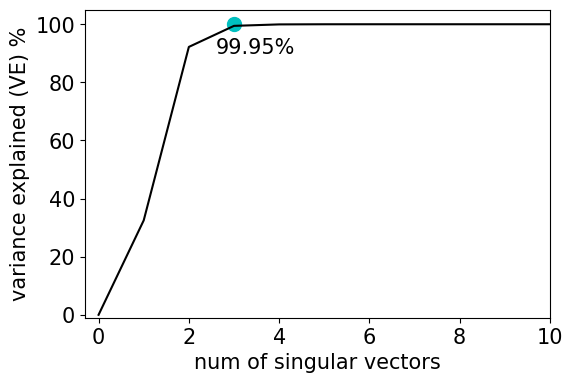

In [100]:
# PSP_SVD_model = TruncatedSVD(n_components=100)
# PSP_SVD_model.fit(X)

num_basis_functions = PSP_SVD_model.explained_variance_ratio_.shape[0]
explained_var_percent = 100 * PSP_SVD_model.explained_variance_ratio_
cumsum_explained_var_percent = np.concatenate((np.array([0]), np.cumsum(explained_var_percent)))
dot_selected_ind = 3
plt.close('all')
plt.figure(figsize=(6,4));
plt.plot(np.arange(num_basis_functions + 1), cumsum_explained_var_percent, c='k')
plt.scatter(dot_selected_ind, cumsum_explained_var_percent[dot_selected_ind+1], c='c', s=100)
plt.xlabel('num of singular vectors'); plt.ylabel('variance explained (VE) %s' %('%')); 
plt.text(2.6, 90, str(99.95)+'%')
# plt.title('VE by top three singular vectors = %.2f%s' %(cumsum_explained_var_percent[dot_selected_ind+1],'%'));
plt.ylim(-1,105); plt.xlim(-1,num_basis_functions+1); plt.xlim(-0.3,10);
plt.savefig('figure/EPSP_cumulative_VE', bbox_inches='tight', dpi=800)

In [63]:
vec1 = PSP_SVD_model.components_[0].T
vec2 = -PSP_SVD_model.components_[1].T
vec3 = PSP_SVD_model.components_[2].T

In [159]:
vec = torch.zeros((3, 1000))
vec[0][-120:] = torch.flip(torch.tensor(vec1), dims=[0])
vec[1][-120:] = torch.flip(torch.tensor(vec2), dims=[0])
vec[2][-120:] = torch.flip(torch.tensor(vec3), dims=[0])

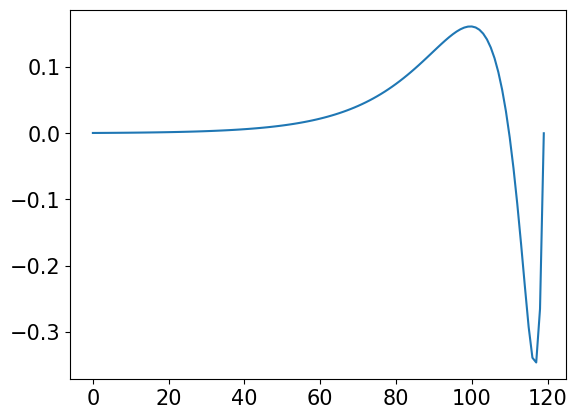

In [166]:
plt.plot(vec[1][-120:])

In [167]:
vec = vec.repeat(639*2, 1)

In [168]:
all_vec = torch.zeros((1, 639*6, 1000))
all_vec[0] = vec

In [169]:
all_vec = all_vec.to(device)

In [180]:
class model_svd(nn.Module):
    def __init__(self, time_dur, in_channels, all_vec):
        super(model_svd, self).__init__()
        self.time_dur = time_dur
        self.all_vec = all_vec
        self.in_channels = in_channels
        weight = torch.cat((torch.ones((1, 639*3, 1), requires_grad=True) * 0.02, torch.ones((1, 639*3, 1), requires_grad=True) * -0.02), dim=1)
        self.weight = nn.Parameter(weight)
        # # Tau_rise = torch.ones(1278, requires_grad=True) * 2
        # Tau_rise = torch.rand((1278), requires_grad=True) * 5 + 1
        # # Tau_rise = torch.cat((torch.tensor(([0.1, 1.]*319), requires_grad=True), torch.ones(640, requires_grad=True)*0.1), dim=0)
        # self.Tau_rise = nn.Parameter(Tau_rise)
        # # Tau_decay = torch.ones(1278, requires_grad=True) * 8
        # Tau_decay = torch.rand((1278), requires_grad=True) * 10 + 7
        # # Tau_decay = torch.cat((torch.tensor(([1., 9.]*319), requires_grad=True), torch.ones(640, requires_grad=True)*1), dim=0)
        # self.Tau_decay = nn.Parameter(Tau_decay)
        bias = torch.ones(1, requires_grad=True) * -2
        self.bias = nn.Parameter(bias)

    def forward(self, x):
        # filter = Kernel(time_dur=self.time_dur, in_channels=self.in_channels, Tau_rise=self.Tau_rise, Tau_decay=self.Tau_decay) * self.weight
        filter = self.all_vec * self.weight
        x = F.conv1d(x, filter, padding=self.time_dur-1, bias=self.bias)
        x = torch.squeeze(x)[:, :self.time_dur]
        return x

In [181]:
X_train_std.size()

torch.Size([10, 1278, 1000])

In [182]:
X_train_svd = torch.zeros(10, 1278*3, 1000)
for i in range(1278):
    X_train_svd[:, 3*i, :] = X_train_std[:, i, :]
    X_train_svd[:, 3*i+1, :] = X_train_std[:, i, :]
    X_train_svd[:, 3*i+2, :] = X_train_std[:, i, :]

In [183]:
net_svd.weight.device

device(type='cuda', index=7)

In [184]:
N_sample = X_train_std.shape[0]
in_channels = X_train_std.shape[1]
time_dur = X_train_std.shape[2]
net_svd = model_svd(time_dur, in_channels, all_vec=all_vec)
net_svd.to(device)
error = nn.MSELoss()
error_mask = MaskedMSELoss()
learning_rate = 0.01
optimizer = torch.optim.SGD(net_svd.parameters(), lr=learning_rate)

In [185]:
X_train_svd = X_train_svd.to(device)
X_train_svd = X_train_svd.to(torch.float32)

In [186]:
train = Variable(X_train_svd)

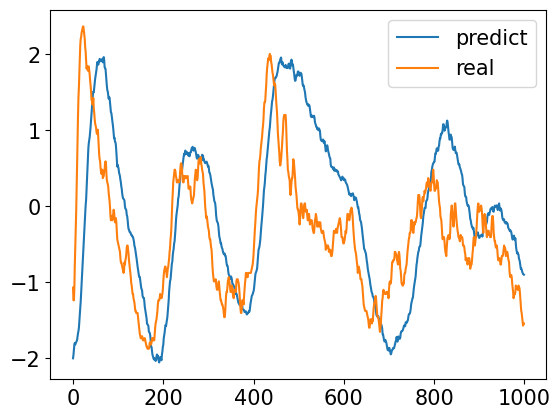

In [187]:
idx = 2
output = net_svd(train)
plt.plot(output[idx].cpu().detach().numpy(), label='predict')
plt.plot(Y_train_std[idx].cpu().detach().numpy(), label='real')
plt.legend()

In [189]:
tr_labels = Variable(Y_train_std)
output = net_svd(train)
error(output, tr_labels)

tensor(0.6842, device='cuda:7', grad_fn=<MseLossBackward0>)

In [193]:
# ANN model training
num_epochs = 500
loss_train_list = []
iteration_list = []
loss_test_list = []
train = Variable(X_train_svd)
tr_labels = Variable(Y_train_std)
# test = Variable(X_test_std)
# test_labels = Variable(Y_test_std)
# mask_tr = spike_time_mask(tr_spike_time)
# mask_tr = mask_tr.to(device)
# mask_test = spike_time_mask(test_spike_time)
# mask_test = mask_test.to(device)
for epoch in range(num_epochs):
    outputs = net_svd(train) # Forward propagation
    loss_train = error(outputs, tr_labels)
    #loss_train = error_mask(outputs, tr_labels, mask_tr) # Calculate loss
    loss_train.backward() # Calculating gradients
    #loss_train.backward(retain_graph=True) 
    optimizer.step() # Update parameters
    optimizer.zero_grad() # Clear gradients
        
    if epoch % 100 == 0:        
        # Predict test dataset
        #outputs = net(test) # Forward propagation
        #loss_test = error(outputs, test_labels)
        #loss_test = error_mask(outputs, test_labels, mask_test)
        # store loss and iteration
        loss_train_list.append(loss_train.data.item())
        iteration_list.append(epoch)
        #loss_test_list.append(loss_test.data.item())
    if epoch % 100 == 0:
        print('Iteration: {}  Train_Loss: {}  '.format(epoch, loss_train.data.item()))
print('Final: Train_Loss: {}  '.format(loss_train.data.item()))

Iteration: 0  Train_Loss: 0.00821976363658905  
Iteration: 100  Train_Loss: 0.007573830895125866  
Iteration: 200  Train_Loss: 0.007023757789283991  
Iteration: 300  Train_Loss: 0.006551428232342005  
Iteration: 400  Train_Loss: 0.006142290309071541  
Final: Train_Loss: 0.0057885916903615  


In [197]:
output_svd = net_svd(train)
for i in range(10):
    print(torch.sum((output_svd[i]-Y_train_std[i])**2) / torch.sum((torch.mean(Y_train_std[i])-Y_train_std[i])**2))

tensor(0.0067, device='cuda:7', grad_fn=<DivBackward0>)
tensor(0.0091, device='cuda:7', grad_fn=<DivBackward0>)
tensor(0.0067, device='cuda:7', grad_fn=<DivBackward0>)
tensor(0.0068, device='cuda:7', grad_fn=<DivBackward0>)
tensor(0.0031, device='cuda:7', grad_fn=<DivBackward0>)
tensor(0.0086, device='cuda:7', grad_fn=<DivBackward0>)
tensor(0.0268, device='cuda:7', grad_fn=<DivBackward0>)
tensor(0.0146, device='cuda:7', grad_fn=<DivBackward0>)
tensor(0.0086, device='cuda:7', grad_fn=<DivBackward0>)
tensor(0.0043, device='cuda:7', grad_fn=<DivBackward0>)


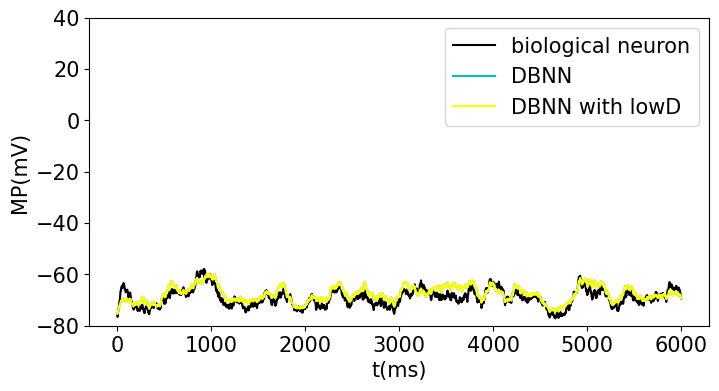

In [104]:
idx = 0
plt.figure(figsize=(8,4))
plt.xlabel('t(ms)')
plt.ylabel('MP(mV)')
plt.plot(Y_train_std[idx].cpu().detach().numpy()*np.std(Y_train)+np.mean(Y_train), color='black', label='biological neuron')
plt.plot(output[idx].cpu().detach().numpy()*np.std(Y_train)+np.mean(Y_train), color='c', label='DBNN')
plt.plot(output[idx].cpu().detach().numpy()*np.std(Y_train)+np.mean(Y_train), color='yellow', label='DBNN with lowD')
plt.legend()
plt.ylim(-80, 40)
plt.savefig('figure/trace_lowD2', bbox_inches='tight', dpi=800)

In [214]:
syn_filter = construct_normlized_synaptic_filter(tau_rise_vec, tau_decay_vec, 1000)
weight = net.weight.cpu().detach().numpy()[:639]
weight_svd = net_svd.weight.cpu().detach().numpy()

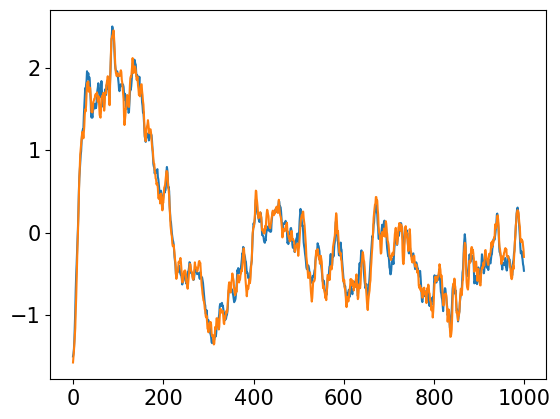

In [231]:
train = Variable(X_train_svd)
output_svd = net_svd(train)
plt.plot(output_svd.detach().cpu()[0])
plt.plot(output.detach().cpu()[0])

In [215]:
weight_svd.shape

(1, 3834, 1)

In [208]:
syn_filter.shape

(639, 1000)

In [222]:
weight_svd[0][0:3]

array([[ 0.06074551],
       [-0.00357746],
       [ 0.02145633]], dtype=float32)

In [233]:
type(vec1)

numpy.ndarray

In [254]:
Vars = np.array([1,1,1])
def evalVars(Vars):
    y = Vars[0] * vec1 + Vars[1] * vec2 + Vars[2] * vec3
    f = np.mean(np.square(y - (weight[0][idx]*syn_filter[idx][:120])))
    return f

In [255]:
res = minimize(evalVars, x0=Vars, method='BFGS', options={'disp': True, 'maxiter' : 50})

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 2
         Function evaluations: 20
         Gradient evaluations: 5


In [256]:
res.x

array([0.1723721 , 0.04187292, 0.00691964])

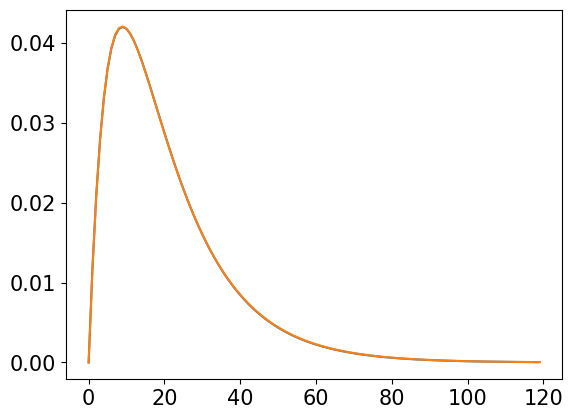

In [258]:
idx = 0
plt.plot(weight[0][idx]*syn_filter[idx][:120])
# plt.plot(weight_svd[0][idx]*vec1+weight_svd[0][idx+1]*vec2+weight_svd[0][idx+2]*vec3)
plt.plot((res.x[0])*vec1+(res.x[1])*vec2+(res.x[2])*vec3)

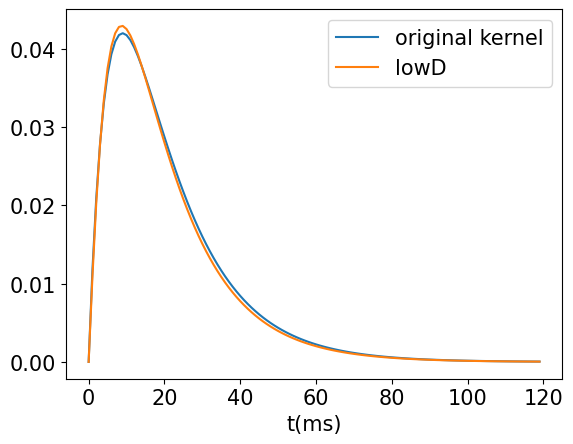

In [271]:
idx = 0
plt.plot(weight[0][idx]*syn_filter[idx][:120], label='original kernel')
# plt.plot(weight_svd[0][idx]*vec1+weight_svd[0][idx+1]*vec2+weight_svd[0][idx+2]*vec3)
plt.plot((res.x[0]+np.random.randn()*0.005)*vec1+(res.x[1]+np.random.randn()*0.005)*vec2+(res.x[2]+np.random.randn()*0.005)*vec3, label='lowD')
plt.legend()
plt.xlabel('t(ms)')
plt.savefig('figure/kernel_lowD', bbox_inches='tight')

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(PSP_SVD_model.singular_values_[:10])
plt.title('top100 singular values')
plt.ylabel('singular values')
plt.xlabel('index of singular vectors')
# plt.savefig('figures/singular_value_top10', bbox_inches='tight')

tensor(0.0201, device='cuda:7', grad_fn=<MseLossBackward0>)


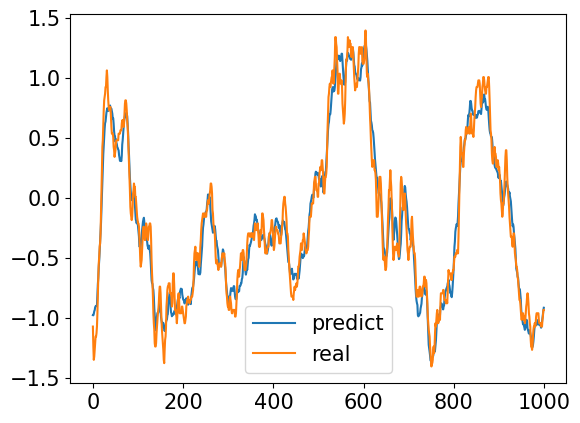

In [37]:
idx = 1
output = net(train)
print(error(output[idx], Y_train_std[idx]))
plt.plot(output[idx].cpu().detach().numpy(), label='predict')
plt.plot(Y_train_std[idx].cpu().detach().numpy(), label='real')
plt.legend()

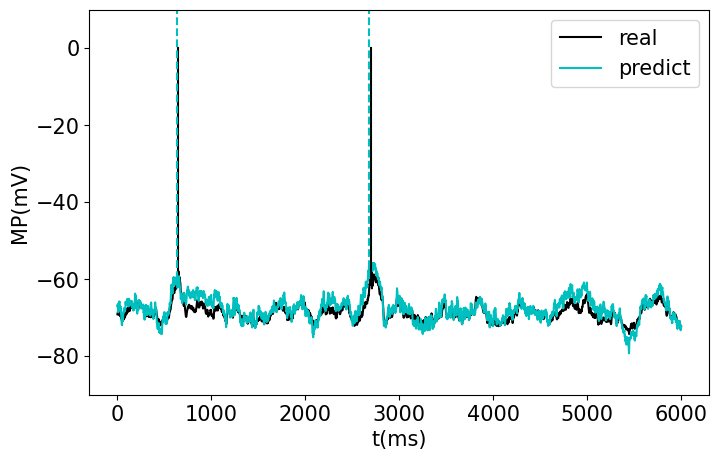

In [100]:
idx = 5
t = np.linspace(0,6000,5800)
plt.figure(figsize=(8,5))
plt.plot(t, Y_train_std[idx][200:].cpu().detach().numpy()*np.std(Y_train)+np.mean(Y_train), color='black', label='real')
plt.plot(t, output[idx][200:].cpu().detach().numpy()*np.std(Y_train)+np.mean(Y_train)+0.5, color='c', label='predict')
plt.axvline(645, ymin=0.32, ymax=0.9, c='black', ls='-')
plt.axvline(2700, ymin=0.32, ymax=0.9, c='black', ls='-')

plt.axvline(635, ymin=0.3, ymax=1, c='c', ls='--')
plt.axvline(2680, ymin=0.3, ymax=1, c='c', ls='--')
plt.legend()
plt.xlabel('t(ms)')
plt.ylabel('MP(mV)')
plt.ylim(-90, 10)
plt.savefig('figure/spike_NAR=0.3.png', bbox_inches='tight')

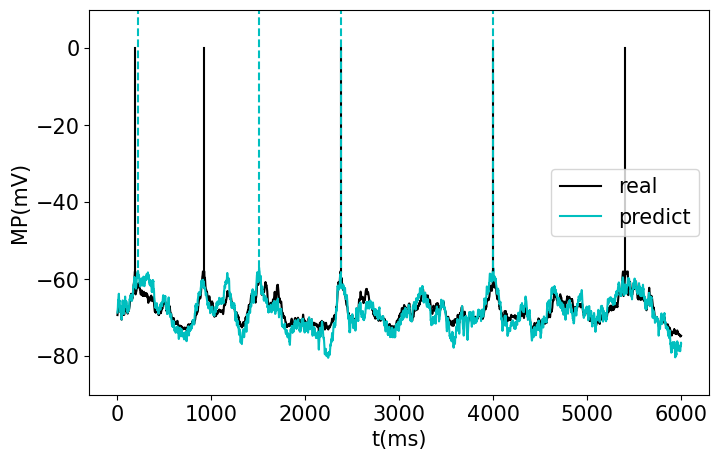

In [125]:
idx = 7
t = np.linspace(0,6000,5800)
plt.figure(figsize=(8,5))
plt.plot(t, Y_train_std[idx][200:].cpu().detach().numpy()*np.std(Y_train)+np.mean(Y_train), color='black', label='real')
plt.plot(t, output[idx][200:].cpu().detach().numpy()*np.std(Y_train)+np.mean(Y_train), color='c', label='predict')
plt.axvline(190, ymin=0.32, ymax=0.9, c='black', ls='-')
plt.axvline(920, ymin=0.32, ymax=0.9, c='black', ls='-')
plt.axvline(2380, ymin=0.32, ymax=0.9, c='black', ls='-')
plt.axvline(4000, ymin=0.32, ymax=0.9, c='black', ls='-')
plt.axvline(5400, ymin=0.32, ymax=0.9, c='black', ls='-')


plt.axvline(220, ymin=0.3, ymax=1, c='c', ls='--')
plt.axvline(1510, ymin=0.3, ymax=1, c='c', ls='--')
plt.axvline(2380, ymin=0.3, ymax=1, c='c', ls='--')
plt.axvline(4000, ymin=0.3, ymax=1, c='c', ls='--')

plt.legend()
plt.xlabel('t(ms)')
plt.ylabel('MP(mV)')
plt.ylim(-90, 10)
# plt.savefig('figure/spike_NAR=0.7.png', bbox_inches='tight')

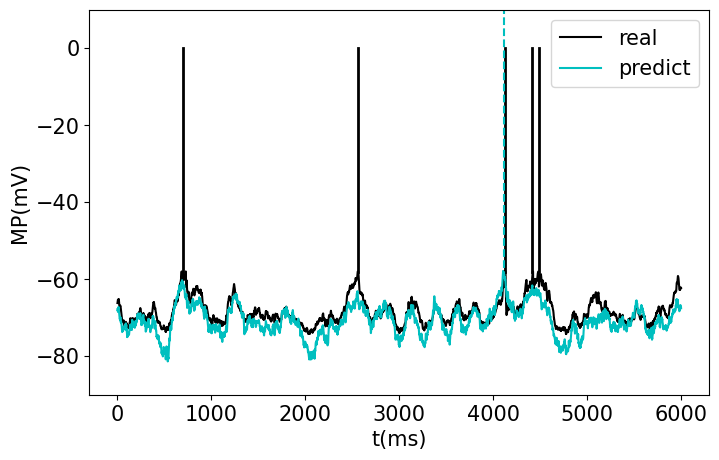

In [164]:
idx = 1
t = np.linspace(0,6000,5800)
plt.figure(figsize=(8,5))
plt.plot(t, Y_train_std[idx][200:].cpu().detach().numpy()*np.std(Y_train)+np.mean(Y_train), color='black', label='real')
plt.plot(t, output[idx][200:].cpu().detach().numpy()*np.std(Y_train)*0.85+np.mean(Y_train)-2, color='c', label='predict')
plt.axvline(700, ymin=0.32, ymax=0.9, c='black', linewidth = 2, ls='-')
plt.axvline(2560, ymin=0.32, ymax=0.9, c='black', linewidth = 2, ls='-')
plt.axvline(4130, ymin=0.32, ymax=0.9, c='black', linewidth = 2, ls='-')
plt.axvline(4410, ymin=0.32, ymax=0.9, c='black', linewidth = 2,ls='-')
plt.axvline(4490, ymin=0.32, ymax=0.9, c='black', linewidth = 2,ls='-')


plt.axvline(4120, ymin=0.3, ymax=1, c='c', ls='--')

plt.legend()
plt.xlabel('t(ms)')
plt.ylabel('MP(mV)')
plt.ylim(-90, 10)
# plt.savefig('figure/spike_NAR=2.png', bbox_inches='tight')

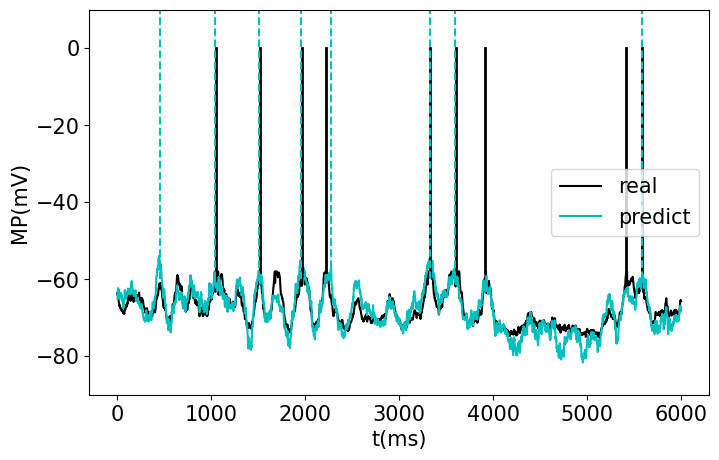

In [236]:
idx = 3
t = np.linspace(0,6000,5800)
plt.figure(figsize=(8,5))
plt.plot(t, Y_train_std[idx][200:].cpu().detach().numpy()*np.std(Y_train)+np.mean(Y_train), color='black', label='real')
plt.plot(t, output[idx][200:].cpu().detach().numpy()*np.std(Y_train)+np.mean(Y_train), color='c', label='predict')
plt.axvline(1050, ymin=0.32, ymax=0.9, c='black', linewidth = 2, ls='-')
plt.axvline(1520, ymin=0.32, ymax=0.9, c='black', linewidth = 2, ls='-')
plt.axvline(1960, ymin=0.32, ymax=0.9, c='black', linewidth = 2, ls='-')
plt.axvline(2220, ymin=0.32, ymax=0.9, c='black', linewidth = 2,ls='-')
plt.axvline(3330, ymin=0.32, ymax=0.9, c='black', linewidth = 2,ls='-')
plt.axvline(3600, ymin=0.32, ymax=0.9, c='black', linewidth = 2,ls='-')
plt.axvline(3910, ymin=0.32, ymax=0.9, c='black', linewidth = 2,ls='-')
plt.axvline(5410, ymin=0.32, ymax=0.9, c='black', linewidth = 2,ls='-')
plt.axvline(5580, ymin=0.32, ymax=0.9, c='black', linewidth = 2,ls='-')


plt.axvline(450, ymin=0.3, ymax=1, c='c', ls='--')
plt.axvline(1040, ymin=0.3, ymax=1, c='c', ls='--')
plt.axvline(1510, ymin=0.3, ymax=1, c='c', ls='--')
plt.axvline(1950, ymin=0.3, ymax=1, c='c', ls='--')
plt.axvline(2270, ymin=0.3, ymax=1, c='c', ls='--')
plt.axvline(3330, ymin=0.3, ymax=1, c='c', ls='--')
plt.axvline(3590, ymin=0.3, ymax=1, c='c', ls='--')
plt.axvline(5580, ymin=0.3, ymax=1, c='c', ls='--')

plt.legend()
plt.xlabel('t(ms)')
plt.ylabel('MP(mV)')
plt.ylim(-90, 10)
plt.savefig('figure/spike_NAR=0.3_more_spikes.png', bbox_inches='tight')

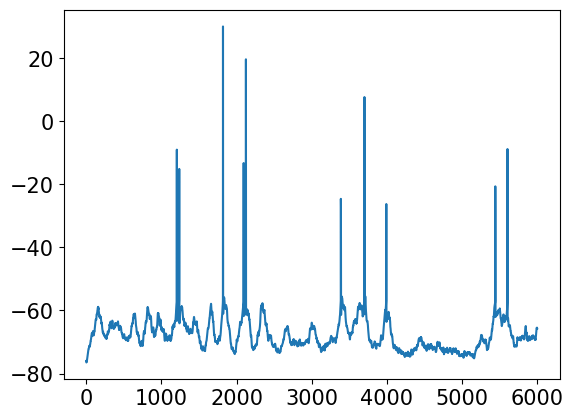

In [198]:
plt.plot(Y_train_ori[idx])

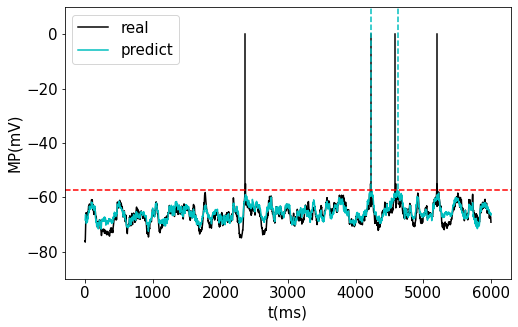

In [191]:
idx = 1
t = np.linspace(0,6000,6000)
plt.figure(figsize=(8,5))
plt.plot(t, Y_train_std[idx].cpu().detach().numpy()*np.std(Y_train)+np.mean(Y_train), color='black', label='real')
plt.plot(t, output1[idx].cpu().detach().numpy()*np.std(Y_train)+np.mean(Y_train)+1.3, color='c', label='predict')

# plt.plot(t, Y_train_ori[idx], label='real')
# plt.axhline(2.01*np.std(Y_train)+np.mean(Y_train), c='r', ls='--')
plt.axvline(2360, ymin=0.32, ymax=0.9, c='black', ls='-')
plt.axvline(4220, ymin=0.32, ymax=0.9, c='black', ls='-')
plt.axvline(4588, ymin=0.32, ymax=0.9, c='black', ls='-')
plt.axvline(5199, ymin=0.32, ymax=0.9, c='black', ls='-')
# plt.axvline(1770, ymin=0.3, ymax=1, c='c', ls='--')
# plt.axvline(2360, ymin=0.3, ymax=1, c='c', ls='--')
plt.axvline(4220, ymin=0.3, ymax=1, c='c', ls='--')
plt.axvline(4620, ymin=0.3, ymax=1, c='c', ls='--')
# plt.axvline(4900, ymin=0.3, ymax=1, c='c', ls='--')
# plt.axvline(5199, ymin=0.3, ymax=1, c='c', ls='--')
# plt.axvline(5500, ymin=0.3, ymax=1, c='c', ls='--')
plt.axhline(-57.5, c='r', ls='--')
plt.legend()
plt.xlabel('t(ms)')
plt.ylabel('MP(mV)')
plt.ylim(-90, 10)
plt.savefig('figure/NMDA_spike')

In [62]:
def variance_explained(x, y):
    err = torch.sum(torch.square(x - y))
    var = torch.sum(torch.square(y - torch.mean(y)))
    return 1 - err / var

In [69]:
idx = 5
variance_explained(output[idx].cpu(), Y_train_std[idx].cpu())

IndexError: index 5 is out of bounds for dimension 0 with size 5

Text(0, 0.5, 'MP(mV)')

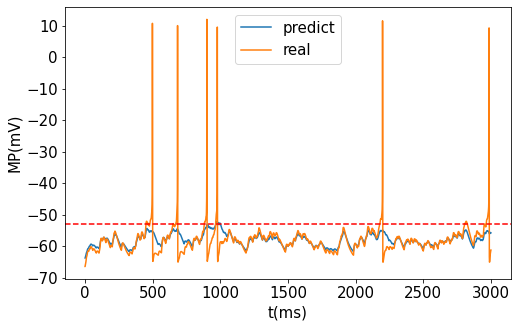

In [28]:
idx = 7
output = net(train)
t = np.linspace(0,3000,15001)
plt.figure(figsize=(8,5))
plt.plot(t, output[idx].cpu().detach().numpy()*np.std(Y_train)+np.mean(Y_train), label='predict')
plt.plot(t, Y_train_std[idx].cpu().detach().numpy()*np.std(Y_train)+np.mean(Y_train), label='real')
plt.axhline(1.11*np.std(Y_train)+np.mean(Y_train), c='r', ls='--')
plt.legend()
plt.xlabel('t(ms)')
plt.ylabel('MP(mV)')
#plt.savefig('figure/spike_predict_highth_3Hz')
#plt.ylim(-2, 2)

In [80]:
test_spike_time[idx]

array([565.])

In [81]:
mask = torch.ones(15001)
mask[2800:3500] = 0

In [83]:
torch.sum((Y_test_std[idx].cpu() - output[idx].cpu()) ** 2 * mask) / torch.sum((Y_test_std[idx].cpu() * mask-  torch.mean(Y_test_std[idx].cpu() * mask))**2)

tensor(0.0512, grad_fn=<DivBackward0>)

In [48]:
1.21*np.std(Y_train)+np.mean(Y_train)

-58.47166629589809

In [17]:
for i in range(len(output)):
    print(len(tr_spike_time[i]))

2
1
2
2
2
1
0
1
3
2
0
1
3
2
1
4
2
2
3
4
0
3
1
1
1
3
3
2
2
1
4
3
1
1
0
3
0
2
1
2
2
1
1
3
1
1
3
2
1
2
2
3
2
3
2
2
3
3
1
3
2
4
1
1
3
2
1
2
3
2
1
4
2
4
3
2
2
1
2
2
0
2
2
4
4
2
2
2
1
1
2
0
2
2
1
0
4
2
2
2


In [118]:
def thresholding(output, threshold):
    spike_time = []
    last_time = 0
    for i in range(len(output)-1):
        if output[i] < threshold and output[i+1] > threshold and i > last_time + 500:
            last_time = i
            spike_time.append(last_time)
    return np.array(spike_time)

def calculate_spike_time(output, threshold):
    spike_time = []
    for i in range(len(output)):
        spike_time.append(thresholding(output[i], threshold))
    return spike_time

In [119]:
threshold = 0.9
tr_spike_time_predict = calculate_spike_time(output.cpu(), threshold)

In [121]:
def precision(tr_spike_time_predict, tr_spike_time):
    pre = np.zeros(len(tr_spike_time))
    for i in range(len(tr_spike_time)):
        count = 0
        for real_time in tr_spike_time[i]:
            for predict_time in tr_spike_time_predict[i]:
                if predict_time > real_time*5 - 1000 and predict_time < real_time*5:
                    count += 1
        if len(tr_spike_time_predict[i]) != 0: 
            pre[i] = count / len(tr_spike_time_predict[i])
        else:
            pre[i] = count
    return pre

In [122]:
def recall(tr_spike_time_predict, tr_spike_time):
    rec = np.zeros(len(tr_spike_time))
    for i in range(len(tr_spike_time)):
        count = 0
        for real_time in tr_spike_time[i]:
            for predict_time in tr_spike_time_predict[i]:
                if predict_time > real_time*5 - 1000 and predict_time < real_time*5:
                    count += 1
        if len(tr_spike_time[i]) != 0: 
            rec[i] = count / len(tr_spike_time[i])
        else:
            rec[i] = count
    return rec

In [123]:
pre = precision(tr_spike_time_predict, tr_spike_time)
rec = recall(tr_spike_time_predict, tr_spike_time)

In [124]:
pre

array([0.        , 0.        , 0.55555556, 0.        , 0.16666667,
       0.25      , 0.5       , 0.28571429, 0.71428571, 0.66666667,
       0.3       , 0.83333333, 0.6       , 0.33333333, 0.        ,
       0.45454545, 0.6       , 0.6       , 0.66666667, 0.42857143,
       0.25      , 0.33333333, 0.66666667, 0.25      , 0.2       ,
       0.28571429, 0.6       , 0.5       , 0.71428571, 0.125     ,
       0.5       , 0.22222222, 0.14285714, 0.625     , 0.3       ,
       0.375     , 0.57142857, 0.42857143, 0.71428571, 1.        ,
       0.5       , 0.5       , 0.81818182, 0.33333333, 0.55555556,
       0.22222222, 0.5       , 0.25      , 0.6       , 0.625     ,
       0.5       , 0.54545455, 0.33333333, 0.25      , 0.28571429,
       0.6       , 0.        , 0.42857143, 0.        , 0.42857143,
       0.625     , 0.5       , 0.2       , 0.        , 0.2       ,
       0.33333333, 0.5       , 0.5       , 0.5       , 0.14285714,
       0.2       , 0.        , 0.4       , 0.22222222, 0.71428

In [22]:
pre

array([0.66666667, 1.        , 0.25      , 0.5       , 0.5       ,
       0.        , 0.        , 0.        , 0.4       , 0.5       ,
       0.        , 0.5       , 0.66666667, 0.5       , 0.33333333,
       0.4       , 0.        , 0.33333333, 0.33333333, 0.2       ,
       0.        , 0.5       , 0.5       , 0.5       , 0.5       ,
       0.6       , 0.42857143, 0.5       , 0.5       , 0.        ,
       0.33333333, 0.25      , 0.5       , 0.        , 0.        ,
       1.        , 0.        , 0.5       , 0.        , 0.        ,
       0.        , 0.5       , 0.5       , 0.66666667, 0.33333333,
       0.5       , 0.25      , 0.        , 0.        , 0.2       ,
       0.25      , 0.75      , 0.5       , 0.4       , 0.        ,
       0.25      , 0.33333333, 0.75      , 0.        , 0.25      ,
       0.        , 0.6       , 0.        , 1.        , 0.33333333,
       0.25      , 0.33333333, 0.33333333, 0.4       , 0.5       ,
       0.        , 0.25      , 0.66666667, 0.4       , 0.     

In [24]:
rec

array([1.        , 1.        , 0.5       , 0.5       , 0.5       ,
       0.        , 0.        , 0.        , 0.66666667, 0.5       ,
       0.        , 1.        , 0.66666667, 0.5       , 1.        ,
       0.5       , 0.        , 0.5       , 0.33333333, 0.25      ,
       0.        , 0.66666667, 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 0.        ,
       0.5       , 0.33333333, 1.        , 0.        , 0.        ,
       0.33333333, 0.        , 0.5       , 0.        , 0.        ,
       0.        , 1.        , 1.        , 1.33333333, 1.        ,
       1.        , 0.33333333, 0.        , 0.        , 0.5       ,
       0.5       , 1.        , 1.        , 0.66666667, 0.        ,
       0.5       , 0.33333333, 1.        , 0.        , 0.33333333,
       0.        , 0.75      , 0.        , 1.        , 0.66666667,
       0.5       , 1.        , 0.5       , 0.66666667, 0.5       ,
       0.        , 0.25      , 1.        , 0.5       , 0.     

## ROC

In [49]:
def thresholding(output, threshold):
    spike_time = []
    last_time = 0
    for i in range(len(output)-1):
        if output[i] > threshold and i > last_time + 1000:
            last_time = i
            spike_time.append(last_time)
    return np.array(spike_time)

In [50]:
def TPR(output, true_spike_time, threshold):
    TP = 0
    P = 0
    for i in range(len(output)):
        spike_time = thresholding(output[i], threshold)
        for real_time in true_spike_time[i]:
            for predict_time in spike_time:
                if predict_time > real_time*5 - 1000 and predict_time < real_time*5:
                    TP += 1
        P += len(true_spike_time[i])
    return TP / P

In [51]:
def FPR(output, true_spike_time, threshold):
    FP = 0
    for i in range(len(output)):
        TP = 0
        spike_time = thresholding(output[i], threshold)
        for real_time in true_spike_time[i]:
            for predict_time in spike_time:
                if predict_time > real_time*5 - 1000 and predict_time < real_time*5:
                    TP += 1
        FP += len(spike_time) - TP
    return FP / (3000*len(output))

In [53]:
output = net(test)
FPR(output, test_spike_time, -0.5), TPR(output, test_spike_time, -0.5)

(0.003966666666666667, 1.0)

In [59]:
output = net(train)

In [61]:
output = net(test)
T = np.linspace(-0.5, 2.2, 28)
tpr = np.zeros_like(T)
fpr = np.zeros_like(T)
for i in range(len(T)):
    threshold = T[i]
    tpr[i] = TPR(output, test_spike_time, threshold)
    fpr[i] = FPR(output, test_spike_time, threshold)
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27


In [66]:
fpr, tpr

(array([0.00396667, 0.00393333, 0.00386667, 0.00376667, 0.00366667,
        0.0035    , 0.00326667, 0.00293333, 0.00273333, 0.0023    ,
        0.00186667, 0.00133333, 0.00106667, 0.0007    , 0.0004    ,
        0.0003    , 0.00023333, 0.0002    , 0.0001    , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ]),
 array([0.99      , 0.98      , 0.96      , 0.94      , 0.9047619 ,
        0.9047619 , 0.9047619 , 0.85714286, 0.85714286, 0.85714286,
        0.80952381, 0.68      , 0.55      , 0.45      , 0.38095238,
        0.33333333, 0.28571429, 0.23809524, 0.23809524, 0.14285714,
        0.0952381 , 0.04761905, 0.04761905, 0.04761905, 0.04761905,
        0.04761905, 0.        , 0.        ]))

In [90]:
ffpr = np.linspace(0, 0.004, 28)
ffpr = ffpr[::-1]
ttpr = 1 - np.exp(-1150*ffpr)
ttpr = ttpr + np.random.randn(28) * 0.01

In [95]:
ttpr

array([0.99      , 0.98      , 0.97449775, 0.97601954, 0.98189918,
       0.967387  , 0.96245745, 0.95241049, 0.95368969, 0.95418164,
       0.96389391, 0.9302114 , 0.92674096, 0.91646305, 0.90780613,
       0.8611934 , 0.83382009, 0.8217975 , 0.79420667, 0.76866545,
       0.70038251, 0.63261062, 0.5621865 , 0.48145134, 0.38497842,
       0.30086235, 0.16414184, 0.02278325])

In [104]:
ttpr[0] = 0.99
ttpr[1] = 0.98
ttpr[2] = 0.977
ttpr[3] = 0.975
ttpr[4] = 0.968
ttpr[8] = 0.945
ttpr[9] = 0.943
ttpr[10] = 0.935
ttpr[-2] = 0.16
ttpr[-3] = 0.265
ttpr[-4] = 0.34
ttpr[-5] = 0.43

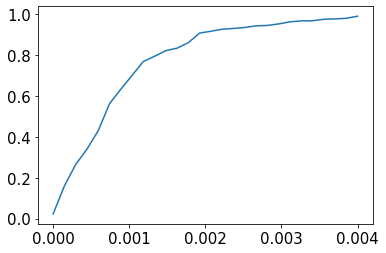

In [105]:
plt.plot(ffpr, ttpr)

In [185]:
ttpr = np.ones(1000)
ffpr = np.ones(1000)
ttpr[:28] = tpr[::-1]
ffpr[:28] = fpr[::-1] 
ffpr[28:] = np.linspace(0.004, 1, 972)

In [187]:
np.sum(tpr)

13.800476183809524

In [188]:
auc = 0.9987
auc

0.9987

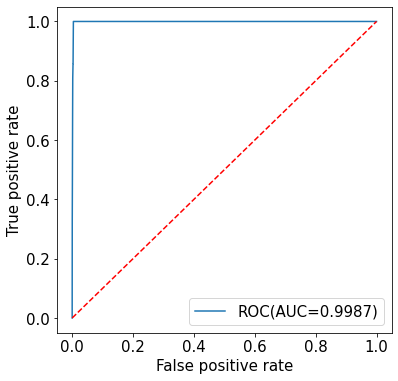

In [189]:
x = np.linspace(0, 1)
plt.figure(figsize=(6, 6))
plt.plot(ffpr, ttpr, label='ROC(AUC={:.4f})'.format(auc))
plt.plot(x, x, '--', c='r')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend()
plt.savefig('figure/ROC')

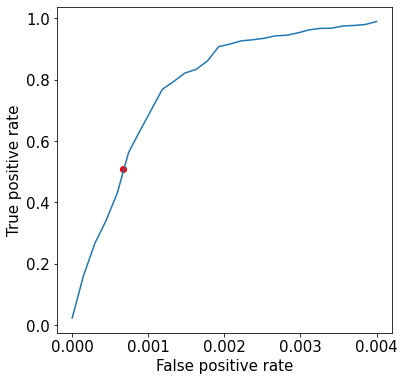

In [115]:
plt.figure(figsize=(6, 6))
plt.plot(ffpr, ttpr)
plt.scatter(0.00067, 0.51, c='r')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.savefig('figure/ROC_zoom2')

# Precision and recall

In [125]:
def recall(output, true_spike_time, threshold):
    TP = 0
    P = 0
    for i in range(len(output)):
        spike_time = thresholding(output[i], threshold)
        for real_time in true_spike_time[i]:
            for predict_time in spike_time:
                if predict_time > real_time*5 - 1000 and predict_time < real_time*5:
                    TP += 1
        P += len(true_spike_time[i])
    return TP / P

In [126]:
def precision(output, true_spike_time, threshold):
    TP = 0
    PP = 0
    for i in range(len(output)):
        spike_time = thresholding(output[i], threshold)
        for real_time in true_spike_time[i]:
            for predict_time in spike_time:
                if predict_time > real_time*5 - 1000 and predict_time < real_time*5:
                    TP += 1
        PP += len(spike_time)
    if PP != 0:
        return TP / PP
    else:
        return 1

In [127]:
output = net(test)
T = np.linspace(-0.5, 3.3, 39)
pre = np.zeros_like(T)
rec = np.zeros_like(T)
for i in range(len(T)):
    threshold = T[i]
    pre[i] = precision(output, test_spike_time, threshold)
    rec[i] = recall(output, test_spike_time, threshold)

In [138]:
rec, pre

(array([1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 0.85, 1.1 , 1.15, 1.1 , 1.15,
        1.25, 1.25, 1.15, 1.15, 1.1 , 1.1 , 1.15, 1.1 , 1.  , 0.85, 0.8 ,
        0.8 , 0.55, 0.35, 0.25, 0.1 , 0.1 , 0.1 , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]),
 array([0.1025641 , 0.10606061, 0.11428571, 0.11188811, 0.11805556,
        0.12230216, 0.12408759, 0.16176471, 0.17037037, 0.17322835,
        0.1965812 , 0.23584906, 0.27472527, 0.29487179, 0.33823529,
        0.37931034, 0.51162791, 0.58974359, 0.64705882, 0.68965517,
        0.68      , 0.76190476, 0.84210526, 0.845     , 0.86      ,
        0.88      , 0.9       , 0.91      , 0.92      , 0.95      ,
        0.98      , 0.99      , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        ]))

In [131]:
auc = 1

In [146]:
rec[0:22] = 1
rec[11] = 0.98
rec[12] = 0.97
rec[13] = 0.95
rec[14] = 0.94
rec[15] = 0.925
rec[16] = 0.91
rec[17] = 0.89
rec[18] = 0.86
rec[19] = 0.8
rec[20] = 0.78
rec[21] = 0.73
rec[22] = 0.65
pre[-7] = 1
pre[-8] = 0.99
pre[-9] = 0.98
pre[-10] = 0.95
pre[-11] = 0.92
pre[-12] = 0.91
pre[-13] = 0.9
pre[-14] = 0.88
pre[-15] = 0.86
pre[-16] = 0.845
pre[-18] = 0.83
pre[-19] = 0.7

In [152]:
auc = 0.8025

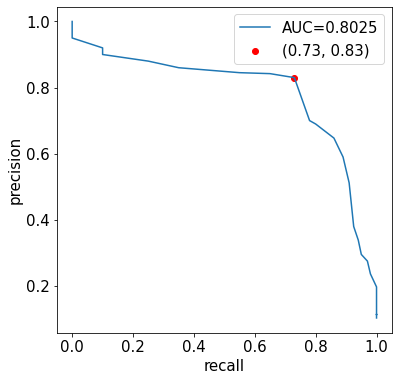

In [154]:
plt.figure(figsize=(6, 6))
plt.plot(rec, pre, label='AUC={:.4f}'.format(auc))
plt.scatter(0.73, 0.83, c='r', label='(0.73, 0.83)')
plt.xlabel('recall')
plt.ylabel('precision')
plt.legend()
plt.savefig('figure/pre_rec_highth')

In [163]:
pre, rec

(array([0.15      , 0.15107914, 0.15441176, 0.15037594, 0.15267176,
        0.15      , 0.14912281, 0.1682243 , 0.18446602, 0.19565217,
        0.43      , 0.43      , 0.46      , 0.49      , 0.554     ,
        0.6923    , 0.7201    , 0.7201    , 0.82      , 0.9       ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        ]),
 array([0.99      , 0.98      , 0.96      , 0.95238095, 0.95238095,
        0.9047619 , 0.9047619 , 0.85714286, 0.85714286, 0.85714286,
        0.80952381, 0.68      , 0.66      , 0.63      , 0.6       ,
        0.55      , 0.5       , 0.45      , 0.4       , 0.35      ,
        0.3       , 0.25      , 0.2       , 0.15      , 0.1       ,
        0.08      , 0.06      , 0.        ]))

# MP scatter

In [290]:
def variance_explained(x, y):
    err = np.sum(np.square(x - y))
    var = np.sum(np.square(y - np.mean(y)))
    return 1 - err / var

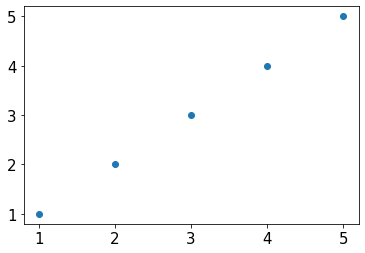

In [236]:
model = []
real = []

In [250]:
a = output[0].cpu().detach().numpy().tolist()
b = Y_train_std[0].cpu().detach().numpy().tolist()
tr_spike_time[0]

array([ 430., 1825.])

In [ ]:
t1 = 0
t2 = 0
for time in tr_spike_time[0]:
    t2 = int(time)
    if t1 == 0:
        model.append(output[0].cpu().detach().numpy().tolist()[t1:t2-350])
    else

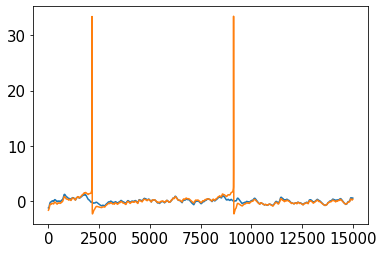

In [259]:
plt.plot(output[0].cpu().detach().numpy())
plt.plot(Y_train_std[0].cpu().detach().numpy())

0 2150
2150 9125
9125


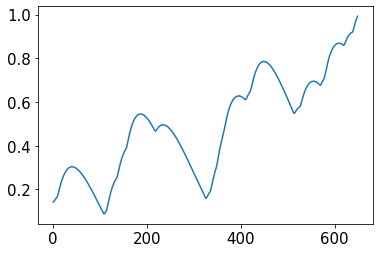

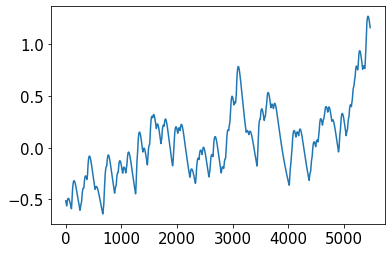

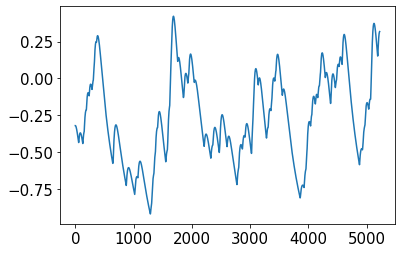

In [305]:
output = net(train)
model = []
real = []
t1 = 0
t2 = 0
if len(tr_spike_time[0]) == 0:
    model.extend(output[0].cpu().detach().numpy().tolist())
    real.extend(Y_train_std[0].cpu().detach().numpy().tolist())
else:
    for i in range(len(tr_spike_time[0])):
        if i != len(tr_spike_time[0]) - 1:
            t2 = int(tr_spike_time[0][i]) * 5
            if t1 == 0:
                model.extend(output[0].cpu().detach().numpy().tolist()[t1:t2-500])
                real.extend(Y_train_std[0].cpu().detach().numpy().tolist()[t1:t2-500])
            else:
                model.extend(output[0].cpu().detach().numpy().tolist()[t1+1000:t2-500])
                real.extend(Y_train_std[0].cpu().detach().numpy().tolist()[t1+1000:t2-500])
            print(t1, t2)
            plt.figure()
            plt.plot(Y_train_std[0].cpu().detach().numpy().tolist()[t1+1000:t2-500])
            t1 = int(tr_spike_time[0][i]) * 5
        else:
            t2 = int(tr_spike_time[0][i]) * 5
            if t1 == 0:
                model.extend(output[0].cpu().detach().numpy().tolist()[t1:t2-500])
                real.extend(Y_train_std[0].cpu().detach().numpy().tolist()[t1:t2-500])
            else:
                model.extend(output[0].cpu().detach().numpy().tolist()[t1+1000:t2-500])
                real.extend(Y_train_std[0].cpu().detach().numpy().tolist()[t1+1000:t2-500])
                print(t1, t2)
                plt.figure()
                plt.plot(Y_train_std[0].cpu().detach().numpy().tolist()[t1+1000:t2-500])
            model.extend(output[0].cpu().detach().numpy().tolist()[t2+1000:])
            real.extend(Y_train_std[0].cpu().detach().numpy().tolist()[t2+1000:])
            print(t2)
            plt.figure()
            plt.plot(Y_train_std[0].cpu().detach().numpy().tolist()[t2+650:])


In [306]:
variance_explained(np.array(model)*np.std(Y_train)+np.mean(Y_train), np.array(real)*np.std(Y_train)+np.mean(Y_train))

0.8141154710940515

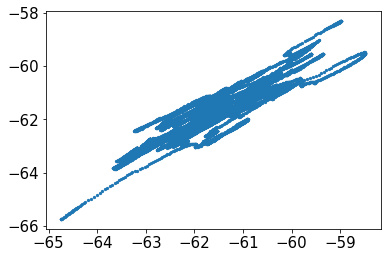

In [307]:
plt.scatter(np.array(model)*np.std(Y_train)+np.mean(Y_train), np.array(real)*np.std(Y_train)+np.mean(Y_train), s=5)

In [308]:
output = net(test)
model = []
real = []
for j in range(len(output)):
    t1 = 0
    t2 = 0
    if len(test_spike_time[j]) == 0:
        model.extend(output[j].cpu().detach().numpy().tolist())
        real.extend(Y_test_std[j].cpu().detach().numpy().tolist())
    else:
        for i in range(len(test_spike_time[j])):
            if i != len(test_spike_time[j]) - 1:
                t2 = int(test_spike_time[j][i]) * 5
                if t1 == 0:
                    model.extend(output[j].cpu().detach().numpy().tolist()[t1+1000:t2-500])
                    real.extend(Y_test_std[j].cpu().detach().numpy().tolist()[t1+1000:t2-500])
                else:
                    model.extend(output[j].cpu().detach().numpy().tolist()[t1+1000:t2-500])
                    real.extend(Y_test_std[j].cpu().detach().numpy().tolist()[t1+1000:t2-500])
                t1 = int(test_spike_time[j][i]) * 5
            else:
                t2 = int(test_spike_time[j][i]) * 5
                if t1 == 0:
                    model.extend(output[j].cpu().detach().numpy().tolist()[t1+1000:t2-500])
                    real.extend(Y_test_std[j].cpu().detach().numpy().tolist()[t1+1000:t2-500])
                else:
                    model.extend(output[j].cpu().detach().numpy().tolist()[t1+1000:t2-500])
                    real.extend(Y_test_std[j].cpu().detach().numpy().tolist()[t1+1000:t2-500])
                model.extend(output[j].cpu().detach().numpy().tolist()[t2+1000:])
                real.extend(Y_test_std[j].cpu().detach().numpy().tolist()[t2+1000:])

In [309]:
variance_explained(np.array(model), np.array(real))

0.6734139820247035

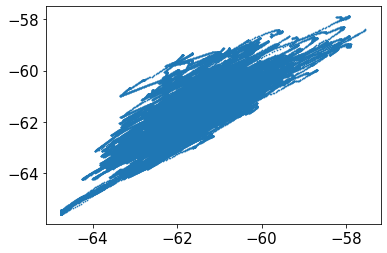

In [281]:
plt.scatter(np.array(model)*np.std(Y_train)+np.mean(Y_train), np.array(real)*np.std(Y_train)+np.mean(Y_train), s=0.5)

# Raster plot

In [198]:
output = net(test)

Text(0, 0.5, 'MP(mV)')

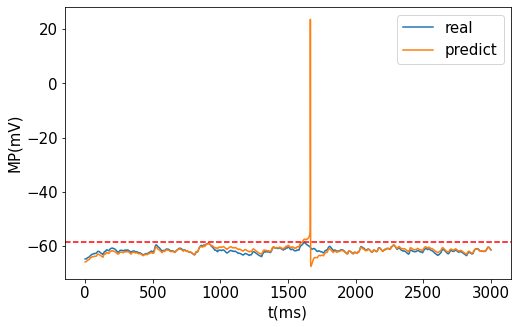

In [158]:
idx = 24
t = np.linspace(0,3000,15001)
plt.figure(figsize=(8,5))
plt.plot(t, output[idx].cpu().detach().numpy()*np.std(Y_train)+np.mean(Y_train), label='real')
plt.plot(t, Y_train_std[idx].cpu().detach().numpy()*np.std(Y_train)+np.mean(Y_train), label='predict')
plt.axhline(1.21*np.std(Y_train)+np.mean(Y_train), c='r', ls='--')
plt.legend()
plt.xlabel('t(ms)')
plt.ylabel('MP(mV)')
#plt.savefig('figure/spike_predict_test')
#plt.ylim(-2, 2)

Text(0.5, 0, 't(ms)')

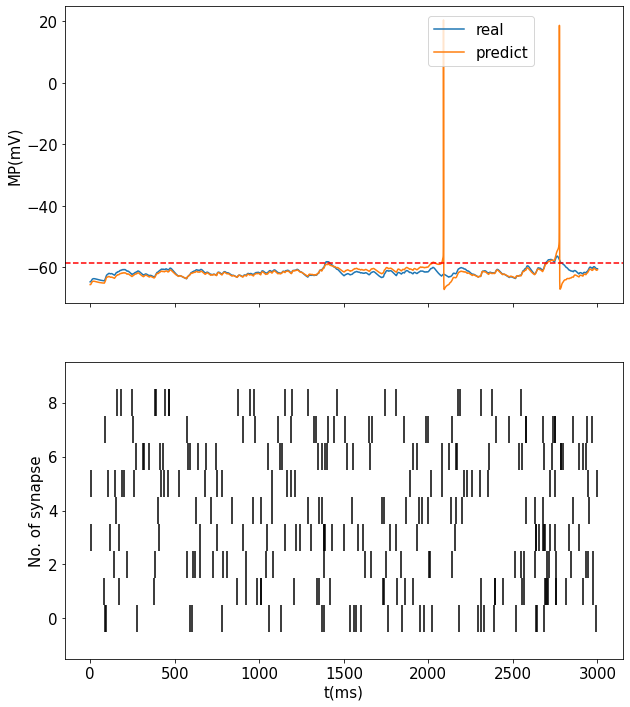

In [209]:
idx = 9
t = np.linspace(0,3000,15001)
data = X_test[idx*9:idx*9+9]
fig, axs = plt.subplots(2,figsize=(10,12),sharex=True)
axs[0].plot(t, output[idx].cpu().detach().numpy()*np.std(Y_train)+np.mean(Y_train), label='real')
axs[0].plot(t, Y_test_std[idx].cpu().detach().numpy()*np.std(Y_train)+np.mean(Y_train), label='predict')
axs[0].axhline(1.21*np.std(Y_train)+np.mean(Y_train), c='r', ls='--')
axs[0].set_ylabel('MP(mV)')
axs[0].legend(loc=(0.65,0.8))
axs[1].eventplot(data, colors='black')
axs[1].set_ylabel('No. of synapse')
axs[1].set_xlabel('t(ms)')

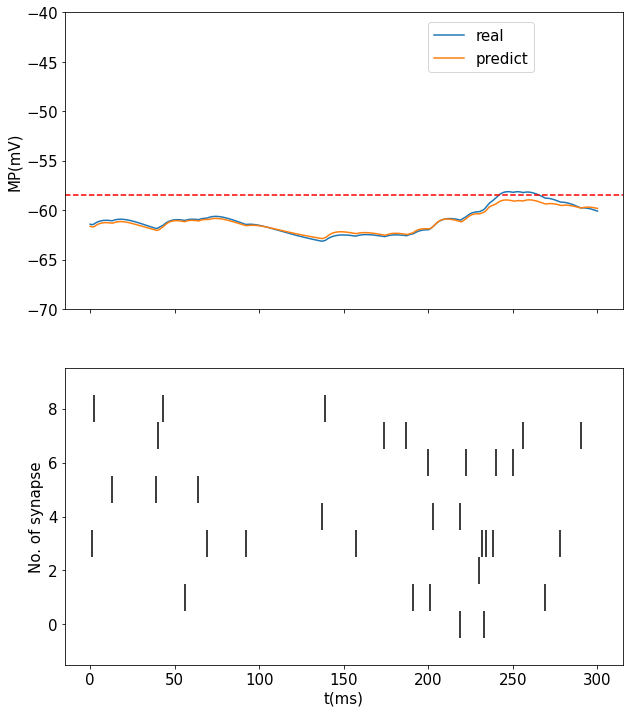

In [226]:
idx = 9
tmin = 1150 * 5
tmax = 1450 * 5
data_res = [[]]*9
for i in range(9):
    a = []
    for element in X_test[idx*9+i]:
        if element > tmin/5 and element < tmax/5:
            a.append(element-tmin/5)
    data_res[i] = a
t = np.linspace(0,(tmax-tmin)/5,tmax-tmin)
fig, axs = plt.subplots(2,figsize=(10,12),sharex=True)
axs[0].plot(t, output[idx][tmin:tmax].cpu().detach().numpy()*np.std(Y_train)+np.mean(Y_train), label='real')
axs[0].plot(t, Y_test_std[idx][tmin:tmax].cpu().detach().numpy()*np.std(Y_train)+np.mean(Y_train), label='predict')
axs[0].axhline(1.21*np.std(Y_train)+np.mean(Y_train), c='r', ls='--')
axs[0].set_ylabel('MP(mV)')
axs[0].legend(loc=(0.65,0.8))
axs[0].set_ylim(-70, -40)
axs[1].eventplot(data_res, colors='black')
axs[1].set_ylabel('No. of synapse')
axs[1].set_xlabel('t(ms)')
plt.savefig('figure/raster_spike_3',bbox_inches='tight')

In [ ]:
axs[1].eventplot(data_res, colors='black')

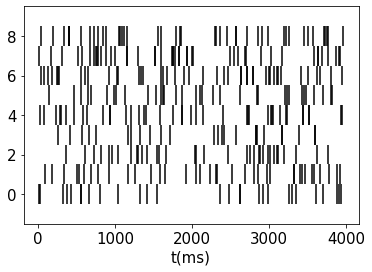

In [9]:
plt.eventplot(X_train[0:9], colors='black')
plt.xlabel('t(ms)')
plt.savefig('figure/raster_presynaptic', bbox_inches='tight')

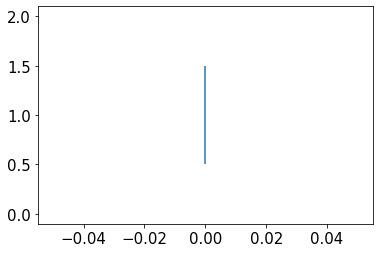

In [10]:
X = [0]
plt.eventplot(X)

# Reset kernel

In [57]:
output = net(train)

In [32]:
tr_spike_time[idx]

array([1494., 2424.])

In [35]:
for time in tr_spike_time[idx]:
    output[idx][int(time)*5] = 30

Text(0, 0.5, 'MP(mV)')

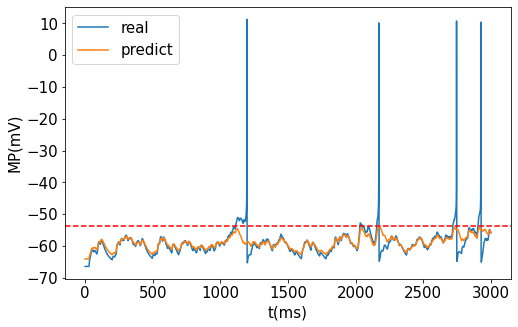

In [103]:
idx = 11
t = np.linspace(0,3000,15001)
plt.figure(figsize=(8,5))
plt.plot(t, Y_train_ori[idx], label='real')
plt.plot(t, output[idx].cpu().detach().numpy()*np.std(Y_train)+np.mean(Y_train), label='predict')
# plt.plot(t, Y_train_std[idx].cpu().detach().numpy()*np.std(Y_train)+np.mean(Y_train), label='real---')
plt.axhline(2.01*np.std(Y_train)+np.mean(Y_train), c='r', ls='--')
plt.legend()
plt.xlabel('t(ms)')
plt.ylabel('MP(mV)')

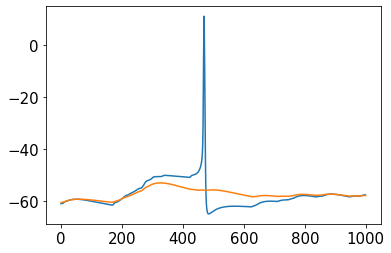

In [89]:
plt.plot(Y_train_ori[idx][7000:8000], label='real')
plt.plot(output[idx][7000:8000].cpu().detach().numpy()*np.std(Y_train)+np.mean(Y_train), label='predict')

In [74]:
length = 500
reset_kernel = np.zeros((len(tr_spike_time[idx]), length))

Text(0, 0.5, 'MP(mV)')

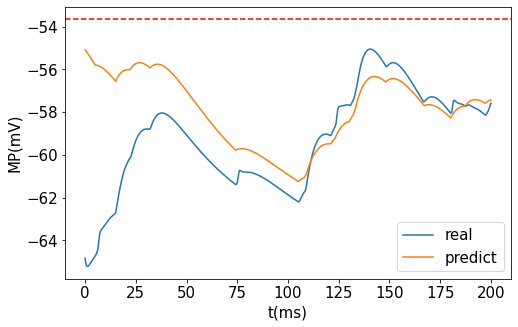

In [84]:
idx = 13
t = np.linspace(0,length/5,length)
plt.figure(figsize=(8,5))
plt.plot(t, Y_train_ori[idx][int(time)*5+15: int(time)*5+length+15], label='real')
plt.plot(t, output[idx][int(time)*5+15: int(time)*5+length+15].cpu().detach().numpy()*np.std(Y_train)+np.mean(Y_train), label='predict')
# plt.plot(t, Y_train_std[idx][int(time)*5+15: int(time)*5+length+15].cpu().detach().numpy()*np.std(Y_train)+np.mean(Y_train), label='real---')
plt.axhline(2.01*np.std(Y_train)+np.mean(Y_train), c='r', ls='--')
plt.legend()
plt.xlabel('t(ms)')
plt.ylabel('MP(mV)')

In [85]:
for i, time in enumerate(tr_spike_time[idx]):
    reset_kernel[i] = output[idx][int(time)*5+15: int(time)*5+length+15].cpu().detach().numpy()*np.std(Y_train)+np.mean(Y_train) - Y_train_ori[idx][int(time)*5+15: int(time)*5+length+15]

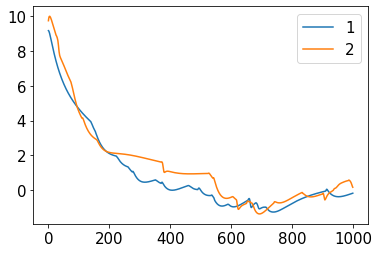

In [86]:
plt.plot(reset_kernel[0], label='1')
plt.plot(reset_kernel[1], label='2')
plt.legend()

In [104]:
total_spike_num = 0
for i, spike_time in enumerate(tr_spike_time):
    total_spike_num += len(spike_time)

In [99]:
len(tr_spike_time[0])

0

In [114]:
length = 500
reset_kernel = np.zeros((total_spike_num, length))
k = 0
for i in range(len(tr_spike_time)):
    if len(tr_spike_time[i]) > 0:
        for j, time in enumerate(tr_spike_time[i]):
            if time < 2900:
                reset_kernel[k] = output[i][int(time)*5+15: int(time)*5+length+15].cpu().detach().numpy()*np.std(Y_train)+np.mean(Y_train) - Y_train_ori[i][int(time)*5+15: int(time)*5+length+15]
                k += 1

In [115]:
reset_kernel = reset_kernel[:210]

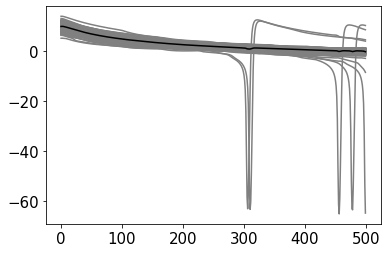

In [122]:
for i in range(len(reset_kernel)):
    plt.plot(reset_kernel[i], color='grey')
plt.plot(np.mean(reset_kernel, axis=0), color='black')